In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from sklearn import datasets

In [3]:
device = torch.device("cpu")

## 2D regression dataset

In [4]:
num_points = 100
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # Remove the CWD from sys.path while we load stuff.


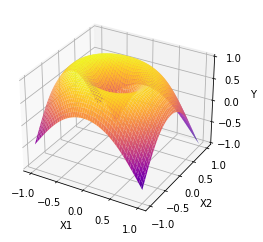

In [5]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

## Making of Bilinear Layer

In [6]:
class Bilinear(nn.Module):
    def __init__(self, grid_width):
        super().__init__()
        self.grid_width = grid_width
        
        self.W = nn.Linear(2, 2, bias=False)
        
        along_row = torch.linspace(0, 1, self.grid_width).reshape(1, -1)
        along_col = torch.linspace(0, 1, self.grid_width).reshape(-1, 1)
        self.Y = nn.Parameter((along_row+along_col)/2)
        print(self.Y)
        
    def forward(self, x):
        x = self.W(x)+0.5
        
        x = x*self.grid_width
        index = torch.clamp(x.data, 0, self.grid_width-2)
        print(x)
        index = torch.floor(index)
        print(index)
        
        ## x on unit square
        _xy = x-index
        print(_xy)
        
        _xc, _yc = tuple(index.type(torch.long).t())
        print(_xc, _yc)
        print(_xc.unsqueeze(1))
        print(_xc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,0],[1,1]]))
        print(_yc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,1],[0,1]]))
        
#         print(self.Y[_xc, _yc])
#         print(self.Y[_xc, _yc+1])
        
        _xc = _xc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,0],[1,1]])
        _yc = _yc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,1],[0,1]])
        mat = self.Y[_xc, _yc]
        print(mat, mat.shape)
        
        _xd = torch.stack([1-_xy[:,0], _xy[:,0]], dim=1).reshape(-1,1,2)
        print(_xd, _xd.shape)
        
        _yd = torch.stack([1-_xy[:,1], _xy[:,1]], dim=1).reshape(-1,2,1)
        print(_yd, _yd.shape)
        ## now bmm
        
        output = torch.bmm(_xd, mat)
        output = torch.bmm(output, _yd)
        print(output.shape)
        
        return output.reshape(-1, 1)

In [7]:
bl = Bilinear(5)

Parameter containing:
tensor([[0.0000, 0.1250, 0.2500, 0.3750, 0.5000],
        [0.1250, 0.2500, 0.3750, 0.5000, 0.6250],
        [0.2500, 0.3750, 0.5000, 0.6250, 0.7500],
        [0.3750, 0.5000, 0.6250, 0.7500, 0.8750],
        [0.5000, 0.6250, 0.7500, 0.8750, 1.0000]], requires_grad=True)


In [8]:
bl(torch.randn(3, 2))

tensor([[ 1.6328,  0.1342],
        [ 9.6704,  7.9628],
        [ 3.7917, -1.0282]], grad_fn=<MulBackward0>)
tensor([[1., 0.],
        [3., 3.],
        [3., 0.]])
tensor([[ 0.6328,  0.1342],
        [ 6.6704,  4.9628],
        [ 0.7917, -1.0282]], grad_fn=<SubBackward0>)
tensor([1, 3, 3]) tensor([0, 3, 0])
tensor([[1],
        [3],
        [3]])
tensor([[[1, 1],
         [2, 2]],

        [[3, 3],
         [4, 4]],

        [[3, 3],
         [4, 4]]])
tensor([[[0, 1],
         [0, 1]],

        [[3, 4],
         [3, 4]],

        [[0, 1],
         [0, 1]]])
tensor([[[0.1250, 0.2500],
         [0.2500, 0.3750]],

        [[0.7500, 0.8750],
         [0.8750, 1.0000]],

        [[0.3750, 0.5000],
         [0.5000, 0.6250]]], grad_fn=<IndexBackward>) torch.Size([3, 2, 2])
tensor([[[ 0.3672,  0.6328]],

        [[-5.6704,  6.6704]],

        [[ 0.2083,  0.7917]]], grad_fn=<ViewBackward>) torch.Size([3, 1, 2])
tensor([[[ 0.8658],
         [ 0.1342]],

        [[-3.9628],
         [ 4.9628]]

tensor([[0.2209],
        [2.2041],
        [0.3454]], grad_fn=<ViewBackward>)

In [9]:
### Finalize Here
class Bilinear(nn.Module):
    def __init__(self, grid_width):
        super().__init__()
        self.grid_width = grid_width
        
        self.W = nn.Linear(2, 2, bias=False)
        
        along_row = torch.linspace(0, 1, self.grid_width).reshape(1, -1)
        along_col = torch.linspace(0, 1, self.grid_width).reshape(-1, 1)
        self.Y = nn.Parameter((along_row+along_col)/2)
        
    def forward(self, x):
        x = self.W(x)+0.5
        
        x = x*self.grid_width
        index = torch.clamp(x.data, 0, self.grid_width-2)
        index = torch.floor(index)
        ## x on unit square
        _xy = x-index
        _xc, _yc = tuple(index.type(torch.long).t())
        _xc = _xc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,0],[1,1]])
        _yc = _yc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,1],[0,1]])
        mat = self.Y[_xc, _yc]
        
        _xd = torch.stack([1-_xy[:,0], _xy[:,0]], dim=1).reshape(-1,1,2)
        _yd = torch.stack([1-_xy[:,1], _xy[:,1]], dim=1).reshape(-1,2,1)
        ## now bmm
        output = torch.bmm(_xd, mat)
        output = torch.bmm(output, _yd)
        return output.reshape(-1, 1)

In [10]:
model = Bilinear(grid_width=100)

In [11]:
print(f"Parameters {sum([p.numel() for p in model.parameters()])}")

Parameters 10004


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [13]:
import time

In [ ]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

hardness = 0
for epoch in range(10000):

    yout = model(xx)
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%50 == 0:
#         fig = plt.figure(figsize=(9,8))
#         ax = fig.gca(projection='3d')

        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        yout_ = yout.data.reshape(Y.shape)
        ax.scatter(X1, X2, yout_, color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
#         plt.show()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:0 | Error:0.1692894697189331
Epoch:50 | Error:0.02055981568992138
Epoch:100 | Error:0.005850579589605331
Epoch:150 | Error:0.0024218549951910973
Epoch:200 | Error:0.0016839210875332355
Epoch:250 | Error:0.001485271262936294
Epoch:300 | Error:0.0014322604984045029
Epoch:350 | Error:0.001638290355913341
Epoch:400 | Error:0.002097835298627615
Epoch:450 | Error:0.0008888879674486816
Epoch:500 | Error:0.000952137284912169
Epoch:550 | Error:0.0008454809430986643
Epoch:600 | Error:0.0010232495842501521
Epoch:650 | Error:0.000731910637114197
Epoch:700 | Error:0.0007805412169545889
Epoch:750 | Error:0.0007151996251195669
Epoch:800 | Error:0.0008754476439207792
Epoch:850 | Error:0.0007728206692263484
Epoch:900 | Error:0.0009646871476434171
Epoch:950 | Error:0.0005308316904120147
Epoch:1000 | Error:0.0006675164913758636
Epoch:1050 | Error:0.0011051379842683673
Epoch:1100 | Error:0.0004821394104510546
Epoch:1150 | Error:0.00043378371628932655
Epoch:1200 | Error:0.00042151479283347726
Epoch:1

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
plt.show()

## Create 2 Output layer
### create bilinear pair layer

In [ ]:
class PairBilinear(nn.Module):
    def __init__(self, dim, grid_width):
        super().__init__()
        self.dim = dim
        self.grid_width = grid_width
        
        self.num_pairs = self.dim // 2
        along_row = torch.linspace(0, 1, self.grid_width).reshape(1, -1)
        along_col = torch.linspace(0, 1, self.grid_width).reshape(-1, 1)
        self.Y = torch.stack([along_row+along_col*0, along_row*0+along_col])
        self.Y = torch.repeat_interleave(self.Y.unsqueeze(0), self.num_pairs, dim=0)
        print(self.Y)
        print(self.Y.shape)
        self.Y = nn.Parameter(self.Y)
        
        self.pairW = torch.eye(2).unsqueeze(0).repeat_interleave(self.num_pairs, dim=0)
        print(self.pairW)
        
    
    def forward(self, x):
        bs = x.shape[0]
        x = x.view(-1, 2)
        
        ### perform pair wise matrix multiplication
        _gi = torch.arange(self.num_pairs).repeat(bs)
        print(_gi)
        _W = self.pairW[_gi]
        print(_W.shape)
        
        x = torch.bmm(x.unsqueeze(1), _W).squeeze(1)
        print(x.shape)
        
        x = x*self.grid_width
        index = torch.clamp(x.data, 0, self.grid_width-2)
        index = torch.floor(index)
        x = x-index
        
        print(index)
        index = (index.repeat_interleave(2, dim=0))
        print(index)
        
        
        _bi = torch.arange(bs).repeat_interleave(self.num_pairs*2)
        print(_bi)
        
        _gi = torch.arange(self.num_pairs).repeat_interleave(2).repeat(bs)
        print(_gi)
        _pi = torch.LongTensor([0,1]).repeat(bs*self.num_pairs)
        print(_pi) ## this is for selecting the 2 among pair
        
        _xc, _yc = tuple(index.type(torch.long).t())
        print(_xc)
        print(_yc)
#         f00, f01, f10, f11 = None

        f00 = self.Y[_gi, _pi, _xc, _yc]
        f01 = self.Y[_gi, _pi, _xc, _yc+1]
        f10 = self.Y[_gi, _pi, _xc+1, _yc]
        f11 = self.Y[_gi, _pi, _xc+1, _yc+1]
        
        print(f00, f01, f10, f11)
        
        a00 = f00
        a10 = f10-f00
        a01 = f01-f00
        a11 = f11-f10-f01+f00
        
        ##### this doubles the multiplication for x,y
#         x = x.repeat_interleave(2, dim=0)
#         print(x)
#         y = a00 + x[:, 0]*a10 + x[:, 1]*a01 + x[:, 0]*x[:, 1]*a11

        ##### this repeats in individual way
        print(x)
        _x, _y = x[:, 0].repeat_interleave(2), x[:, 1].repeat_interleave(2)
        y = a00 + _x*a10 + _y*a01 + _x*_y*a11
        
        ### now 
        y = y.view(bs, -1)
        print(y)
        pass

In [ ]:
pb = PairBilinear(6, 5)

In [ ]:
pb(A)

In [ ]:
# tensor([[0., 2., 2., 0.],
#         [0., 0., 1., 1.],
#         [3., 2., 3., 2.]])

In [ ]:
A = torch.randn(2, 6)*0.5+0.5
A

### Now cleaning the module and testing on 2D

In [ ]:
class PairBilinear(nn.Module):
    def __init__(self, dim, grid_width):
        super().__init__()
        self.dim = dim
        self.grid_width = grid_width
        
        self.num_pairs = self.dim // 2
        along_row = torch.linspace(0, 1, self.grid_width).reshape(1, -1)
        along_col = torch.linspace(0, 1, self.grid_width).reshape(-1, 1)
        self.Y = torch.stack([along_row+along_col*0, along_row*0+along_col])
        self.Y = torch.repeat_interleave(self.Y.unsqueeze(0), self.num_pairs, dim=0)
        self.Y = nn.Parameter(self.Y)
        
        self.pairW = torch.eye(2).unsqueeze(0).repeat_interleave(self.num_pairs, dim=0)*0.5
        self.pairW = nn.Parameter(self.pairW)
    
    def forward(self, x):
        bs = x.shape[0]
        x = x.view(-1, 2)
        
        _wi = torch.arange(self.num_pairs).repeat(bs)
        _W = self.pairW[_wi]
        x = torch.bmm(x.unsqueeze(1), _W).squeeze(1)
        
        x = x*self.grid_width
        index = torch.clamp(x.data, 0, self.grid_width-2)
        index = torch.floor(index)
        x = x-index
        
        index = (index.repeat_interleave(2, dim=0))
        
        _bi = torch.arange(bs).repeat_interleave(self.num_pairs*2)
        _gi = torch.arange(self.num_pairs).repeat_interleave(2).repeat(bs)
        _pi = torch.LongTensor([0,1]).repeat(bs*self.num_pairs)
        _xc, _yc = tuple(index.type(torch.long).t())

        f00 = self.Y[_gi, _pi, _xc, _yc]
        f01 = self.Y[_gi, _pi, _xc, _yc+1]
        f10 = self.Y[_gi, _pi, _xc+1, _yc]
        f11 = self.Y[_gi, _pi, _xc+1, _yc+1]
        
        a00 = f00
        a10 = f10-f00
        a01 = f01-f00
        a11 = f11-f10-f01+f00
        
        ##### this doubles the multiplication for x,y
#         x = x.repeat_interleave(2, dim=0)
#         y = a00 + x[:, 0]*a10 + x[:, 1]*a01 + x[:, 0]*x[:, 1]*a11

        ##### this repeats in individual way
        _x, _y = x[:, 0].repeat_interleave(2), x[:, 1].repeat_interleave(2)
        y = a00 + _x*a10 + _y*a01 + _x*_y*a11

        ### now 
        y = y.view(bs, -1)
        return y

In [ ]:
class BiasLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.bias = nn.Parameter(torch.ones(dim)*1)
        
    def forward(self, x):
        return x+self.bias

In [ ]:
pbil = PairBilinear(2, 10)

In [ ]:
yout = pbil(torch.randn(10, 2))
yout.shape

In [ ]:
model = nn.Sequential(
        BiasLayer(2),
        PairBilinear(2, 4),
        nn.Linear(2, 1)
                )

In [ ]:
print(f"Parameters {sum([p.numel() for p in model.parameters()])}")

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [ ]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

hardness = 0
for epoch in range(10000):

    yout = model(xx)#[:, :1]
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
#         fig = plt.figure(figsize=(9,8))
#         ax = fig.gca(projection='3d')

        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        yout_ = yout.data.reshape(Y.shape)
        ax.scatter(X1, X2, yout_, color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
#         plt.show()

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
plt.show()

In [ ]:
def get_pair(inp_dim, step=1):
    dim = 2**int(np.ceil(np.log2(inp_dim)))
    assert isinstance(step, int), "Step must be integer"
    
    blocks = (2**step)
    range_ = dim//blocks
    adder_ = torch.arange(0, range_)*blocks
    
    pairs_ = torch.Tensor([0, blocks//2])
    repeat_ = torch.arange(0, blocks//2).reshape(-1,1)
    block_map = (pairs_+repeat_).reshape(-1)
    
    reorder_for_pair = (block_map+adder_.reshape(-1,1)).reshape(-1)
    indx = reorder_for_pair.type(torch.long)
    indx = indx[indx<inp_dim]
    
    rev_indx = torch.argsort(indx)
    return indx, rev_indx

In [ ]:
get_pair(60, 3)

In [ ]:
(tensor([0, 4, 1, 5, 2, 6, 3, 7]), tensor([0, 2, 4, 6, 1, 3, 5, 7]))
(tensor([0, 4, 1, 5, 2, 3]), tensor([0, 2, 4, 5, 1, 3]))

In [ ]:
int(np.ceil(np.log2(8)))

In [ ]:
class FactorizedPairBilinearSpline(nn.Module):
    
    def __init__(self, input_dim, grid_width):
        super().__init__()
        assert input_dim%2 == 0, "Input dim must be even number"
        self.input_dim = input_dim
        num_layers = int(np.ceil(np.log2(8)))
            
        self.facto_nets = []
        self.idx_revidx = []
        for i in range(num_layers):
            idrid = self.get_pair(self.input_dim, i+1)
            net = PairBilinear(self.input_dim, grid_width)
            self.facto_nets.append(net)
            self.idx_revidx.append(idrid)
        self.facto_nets = nn.ModuleList(self.facto_nets)
            
    def get_pair(self, inp_dim, step=1):
        dim = 2**int(np.ceil(np.log2(inp_dim)))
        assert isinstance(step, int), "Step must be integer"

        blocks = (2**step)
        range_ = dim//blocks
        adder_ = torch.arange(0, range_)*blocks

        pairs_ = torch.Tensor([0, blocks//2])
        repeat_ = torch.arange(0, blocks//2).reshape(-1,1)
        block_map = (pairs_+repeat_).reshape(-1)

        reorder_for_pair = (block_map+adder_.reshape(-1,1)).reshape(-1)
        indx = reorder_for_pair.type(torch.long)
        indx = indx[indx<inp_dim]

        rev_indx = torch.argsort(indx)
        return indx, rev_indx
    
    def forward(self, x):
        ## swap first and then forward and reverse-swap
        y = x
        for i in range(len(self.facto_nets)):
            idx, revidx = self.idx_revidx[i]
            y = y[:, idx]
            y = self.facto_nets[i](y) 
            y = y[:, revidx]
        y = x + y ## this is residual addition... remove if only want feed forward
        return y

In [ ]:
fpbs = FactorizedPairBilinearSpline(6, 5)

In [ ]:
param_count = sum([torch.numel(p) for p in fpbs.parameters()])
param_count

In [ ]:
fpbs.idx_revidx

In [ ]:
fpbs(torch.randn(3, 6))